In [2]:
import pandas as pd
import jieba
import numpy
 
df_news=pd.read_table('data/val.txt',names=['category','theme','URL','content'],encoding='utf-8')
df_news=df_news.dropna()
# print(df_news.head())
# print(df_news.shape)
 
#分词：使用结巴分词器
content=df_news.content.values.tolist()
#print(content[1000])
 
content_S=[]
for line in content:
    current_segment=jieba.lcut(line)
    if len(current_segment)>1 and current_segment !='r\n':
        content_S.append(current_segment)
#print(content_S[1000])
 
df_content=pd.DataFrame({'content_S':content_S})
#print(df_content.head())
 
stopwords=pd.read_csv("stopwords.txt",index_col=False,sep='\t',quoting=3,names=['stopword'],encoding='utf-8')
# print(stopwords.head())
 
def drop_stopwords(contents,stopwords):
    contents_clean=[]
    all_words=[]
    for line in contents:
        line_clean=[]
        for word in line:
            if word in stopwords:
                continue
            line_clean.append(word)
            all_words.append(str(word))
        contents_clean.append(line_clean)
    return contents_clean,all_words
 
contents=df_content.content_S.values.tolist()
stopwords=stopwords.stopword.values.tolist()
contents_clean,all_words=drop_stopwords(contents,stopwords)
 
 
df_content=pd.DataFrame({'contents_clean':contents_clean})
# print(df_content.head())
 
df_all_words=pd.DataFrame({'all_words':all_words})
# print(df_all_words.head())
new_df_all_words=df_all_words.explode('all_words')
print(new_df_all_words)
#se = df.explode("s").rename(columns={"s": "word"}).groupby("word").apply(len)
words_count=new_df_all_words.groupby(by=['all_words']).apply(len)
print(words_count)
words_count_df=pd.DataFrame(words_count)#,columns=['all_words','count']
words_count_df=words_count_df.reset_index()
words_count_df.columns=['all_words','count']
words_count=words_count_df.sort_values(by=["count"],ascending=False)
# print(words_count.head())


       all_words
0            经销商
1             电话
2             试驾
3             订车
4              Ｕ
...          ...
993923        美女
993924        日本
993925        美女
993926        韩国
993927        美女

[993928 rows x 1 columns]
all_words
D      4
F      3
P      3
S      2
T      3
    ... 
ｗ    401
ｘ    197
ｙ    480
ｚ     81
￡      2
Length: 104784, dtype: int64


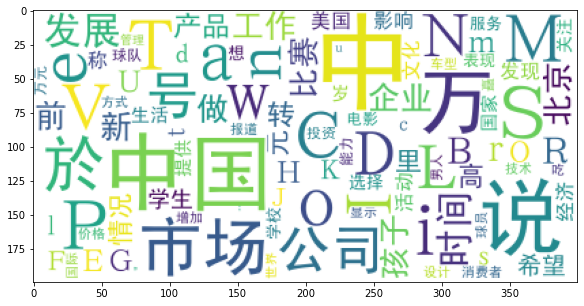

In [3]:
 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize']=(10.0,5.0)
 
wordcloud=WordCloud(font_path="./data/simhei.ttf",background_color='white',max_font_size=80)
word_frequence={x[0]:x[1] for x in words_count.head(100).values}
wordcloud=wordcloud.fit_words(word_frequence)
plt.imshow(wordcloud)
plt.show()
 


In [4]:
#TF-IDF提取关键词
import jieba.analyse
index=1000
print(df_news['content'][index])
content_S_str="".join(content_S[index])
# print(" ".join(jieba.analyse.extract_tags(content_S_str,topK=5,withWeight=False)))
 


阿里巴巴集团昨日宣布，将在集团管理层面设立首席数据官岗位（Ｃｈｉｅｆ　Ｄａｔａ　Ｏｆｆｉｃｅｒ），阿里巴巴Ｂ２Ｂ公司ＣＥＯ陆兆禧将会出任上述职务，向集团ＣＥＯ马云直接汇报。＞菹ぃ和６月初的首席风险官职务任命相同，首席数据官亦为阿里巴巴集团在完成与雅虎股权谈判，推进“ｏｎｅ　ｃｏｍｐａｎｙ”目标后，在集团决策层面新增的管理岗位。０⒗锛团昨日表示，“变成一家真正意义上的数据公司”已是战略共识。记者刘夏


In [5]:
#LDA:主题模型
from gensim import corpora,models,similarities
import gensim
 
#做映射，相当于阅读
dictionary=corpora.Dictionary(contents_clean)
corpus=[dictionary.doc2bow(sentence) for sentence in contents_clean]
 
lda=gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dictionary,num_topics=200)
#一号分类结果
print(lda.print_topic(1,topn=5))

for topic in lda.print_topics(num_topics=20,num_words=5):
    print(topic[1])
 
df_train=pd.DataFrame({'contents_clean':contents_clean,'label':df_news['category']})
print(df_train.head())
#['汽车' '财经' '科技' '健康' '体育' '教育' '文化' '军事' '娱乐' '时尚']
print(df_train.label.unique())
 
 
label_mapping={"汽车":1,"财经":2,"科技":3,"健康":4,"体育":5,"教育":6,
               "文化":7,"军事":8,"娱乐":9,"时尚":10}
df_train['label']=df_train['label'].map(label_mapping)
print(df_train.head())
 
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(df_train['contents_clean'].values,df_train['label'].values)
print(x_train[0][1])
 
words=[]
for line_index in range(len(x_train)):
    try:
        words.append(' '.join(x_train[line_index]))
    except:
        print(line_index)
print(words[0])
 
 
from sklearn.feature_extraction.text import CountVectorizer
vec=CountVectorizer(analyzer='word',max_features=4000,lowercase=False)
vec.fit(words)
 
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()
classifier.fit(vec.transform(words),y_train)
 
test_words=[]
for line_index in range(len(x_test)):
    try:
        test_words.append(' '.join(x_test[line_index]))
    except:
        print(line_index)
print(test_words[0])
 
print(classifier.score(vec.transform(test_words),y_test))
 
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer(analyzer='word',max_features=4000,lowercase=False)
vectorizer.fit(words)
 
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()
classifier.fit(vectorizer.transform(words),y_train)
 
print(classifier.score(vectorizer.transform(test_words),y_test))

0.024*"央视" + 0.018*"圈内" + 0.011*"节目" + 0.011*"裸泳" + 0.010*"帮"
0.021*"场上" + 0.017*"赛" + 0.014*"德国" + 0.008*"杀" + 0.008*"子"
0.016*"奶粉" + 0.016*"着装" + 0.016*"段" + 0.013*"疼" + 0.009*"滕"
0.087*"学生" + 0.018*"侮辱" + 0.017*"党" + 0.015*"言语" + 0.012*"这段"
0.025*"中国" + 0.020*"海上" + 0.019*"俄" + 0.018*"海域" + 0.018*"海洋"
0.022*"街头" + 0.020*"「" + 0.013*"备战" + 0.011*"酥" + 0.010*"卡西"
0.030*"按摩" + 0.027*"脊柱" + 0.014*"腰部" + 0.013*"部位" + 0.009*"根部"
0.017*"励志" + 0.016*"一支" + 0.016*"网友" + 0.013*"报名" + 0.010*"作品"
0.021*"芒果" + 0.017*"土" + 0.015*"辅导班" + 0.014*"笑" + 0.013*"广西"
0.017*"Ｎ" + 0.016*"分钟" + 0.016*"气场" + 0.013*"骂" + 0.008*"蛲"
0.034*"台北" + 0.016*"台湾" + 0.014*"大陆" + 0.012*"中国" + 0.012*"嘉宾"
0.056*"男友" + 0.034*"爱情" + 0.015*"悉数" + 0.013*"无聊" + 0.011*"铱"
0.021*"勇敢" + 0.019*"同学" + 0.014*"复出" + 0.009*"公司" + 0.008*"掷"
0.010*"胶原蛋白" + 0.010*"风雨" + 0.009*"受邀" + 0.008*"倒入" + 0.008*"率领"
0.009*"蒂" + 0.006*"Ｆ" + 0.006*"会否" + 0.006*"Ｍ" + 0.006*"想必"
0.012*"道歉" + 0.011*"菠菜" + 0.011*"礁" + 0.010*"分校" + 0.009*"中"
0.048*"英雄" +